<a href="https://colab.research.google.com/github/nribot/smoking/blob/main/Smoking_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instrucciones
* Leer archivo con los datos
* Preprocesado de los datos: eleimiar columnos que no nos interesen, limpiar * valores perdidos, cambiar etiqueta de las clases a 0, 1, 2, 3, .... en caso de * que sean strings, codificar o transformar columnas que sean texto, ....
* Separar entre X e Y
* Separar en entrenamiento y test (si no nos lo dan por defecto)
* Normalizar
* Entrenar los modelos que queramos de clasificación: Predicciones, evaluación * (alguna métrica de clasificación que hemos visto o varias de ellas)
* Comparar los resultados de todos los modeos y quedarnos con el mejor.
* Añadir validación cruzada a los hiperparámetros que considere oportuno!!!

In [46]:
# Para visualizar gráficas en notebooks
%matplotlib inline

# Para acceder al archivo guardado en drive
from google.colab import drive

# Librerías utilizadas
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

### Carga de datos


Datos obtenidos de https://www.kaggle.com/datasets/kukuroo3/body-signal-of-smoking

La variable de salida es `smoking` que tiene dos valores en este dataset, según la documentación:
* 0 = no han fumado nunca
* 1 = fumaban anteriormente (pero ya no)

Había una tercera categoría, fumadores activos, que se ha eliminado ya del dataset.

In [4]:
#import kaggle
#! kaggle datasets download gauravduttakiit/cassava-leaf-disease-classificatio

In [5]:
drive.mount('/content/drive')

data = pd.read_csv('drive/MyDrive/Datasets/smoking.csv')

data.head()

Mounted at /content/drive


,ID,gender,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),...,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,oral,dental caries,tartar,smoking
0,0,F,40,155,60,81.3,1.2,1.0,1.0,1.0,...,12.9,1.0,0.7,18.0,19.0,27.0,Y,0,Y,0
1,1,F,40,160,60,81.0,0.8,0.6,1.0,1.0,...,12.7,1.0,0.6,22.0,19.0,18.0,Y,0,Y,0
2,2,M,55,170,60,80.0,0.8,0.8,1.0,1.0,...,15.8,1.0,1.0,21.0,16.0,22.0,Y,0,N,1
3,3,M,40,165,70,88.0,1.5,1.5,1.0,1.0,...,14.7,1.0,1.0,19.0,26.0,18.0,Y,0,Y,0
4,4,F,40,155,60,86.0,1.0,1.0,1.0,1.0,...,12.5,1.0,0.6,16.0,14.0,22.0,Y,0,N,0


In [6]:
original_dim = data.shape
print("El dataset contiene", data.shape[0], "observaciones de", data.shape[1], "variables.")

El dataset contiene 55692 observaciones de 27 variables.


Examinamos el tipo de las columnas y si hay nulos:

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55692 entries, 0 to 55691
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   55692 non-null  int64  
 1   gender               55692 non-null  object 
 2   age                  55692 non-null  int64  
 3   height(cm)           55692 non-null  int64  
 4   weight(kg)           55692 non-null  int64  
 5   waist(cm)            55692 non-null  float64
 6   eyesight(left)       55692 non-null  float64
 7   eyesight(right)      55692 non-null  float64
 8   hearing(left)        55692 non-null  float64
 9   hearing(right)       55692 non-null  float64
 10  systolic             55692 non-null  float64
 11  relaxation           55692 non-null  float64
 12  fasting blood sugar  55692 non-null  float64
 13  Cholesterol          55692 non-null  float64
 14  triglyceride         55692 non-null  float64
 15  HDL                  55692 non-null 

Eliminamos la variable `ID`

In [8]:
data = data.drop(labels=['ID'], axis=1)

### Examen y tranformación de los datos

#### Variables categóricas

Visualizamos las columnas categóricas, incluyendo la variable de salida.

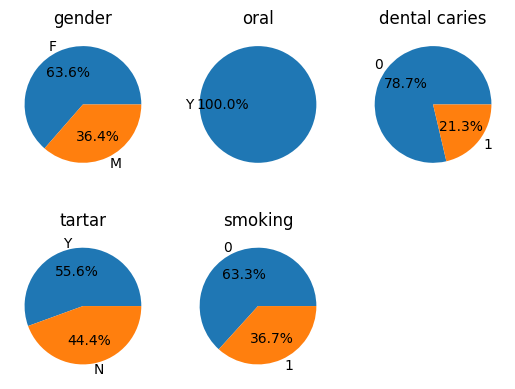

In [9]:
categorical = ['gender', 'oral', 'dental caries', 'tartar', 'smoking']

for i in categorical:
  idx = categorical.index(i)
  ax1 = plt.subplot(2,3, idx+1)
  ax1.pie(data[i].value_counts(),
          labels=data[i].unique(),
          autopct = '%1.1f%%'
          )
  ax1.set_title(i)

Vemos que la categoría `oral` no nos aporta información ya que todos las observaciones tienes la misma respuesta, la eliminamos.

In [10]:
data = data.drop(labels=['oral'], axis=1)
data.shape

(55692, 25)

Las columnas 'gender' y 'tartar' solo contienen dos categorías; las cambiamos a variables numéricas.

* Gender: 0 = male, 1 = female
* Tartar  0 = N, 1 = Y

In [11]:
data['gender'].replace('M', 0, inplace=True)
data['gender'].replace('F', 1, inplace=True)
data.replace('N', 0, inplace=True)
data.replace('Y', 1, inplace=True)
#data.loc[:,['gender', 'tartar']].head()

Además, vemos que el dataset tiene mucha más presencia de personas no fumadoras y de mujeres, vamos a examinar si hay alguna relación.

In [12]:
CrosstabResult=pd.crosstab(index=data['gender'],columns=data['smoking'])
print(CrosstabResult)

smoking      0      1
gender               
0        15805  19596
1        19432    859


In [13]:
np.corrcoef(data['smoking'], data['gender'])

array([[ 1.        , -0.51033967],
       [-0.51033967,  1.        ]])

Parece que sí hay una clara distribución por sexo: la gran mayoría de fumadores previos son hombres.

#### Variables numéricas
Examinamos ahora las variables numéricas.

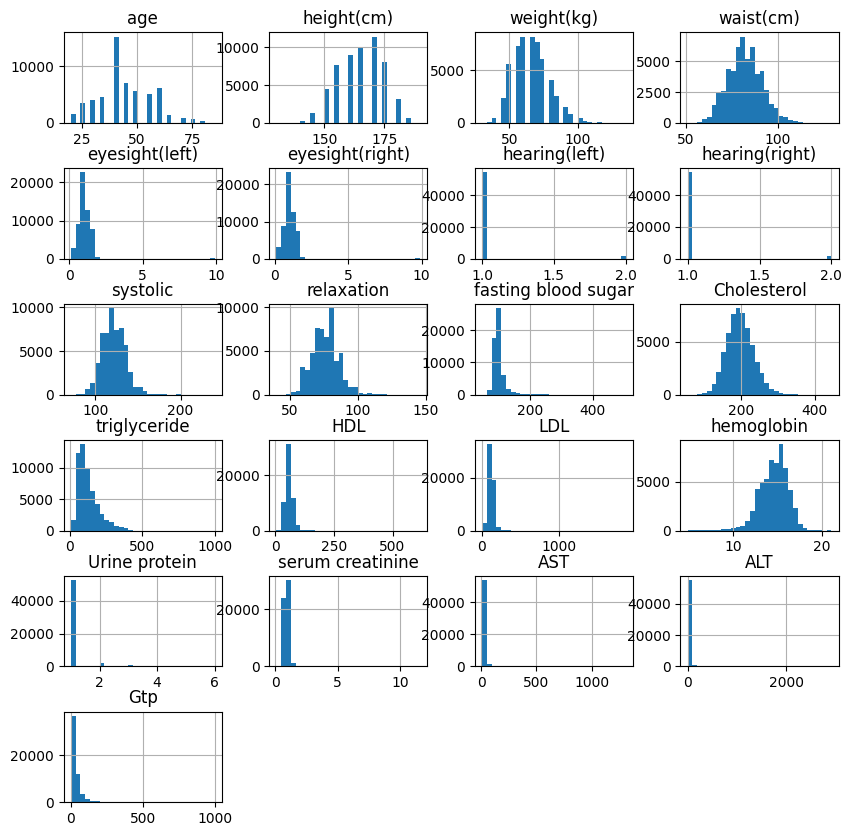

In [14]:
# separamos las variables numéricas
datanum = data.loc[:, ~data.columns.isin(categorical)]

datanum.hist(bins=30, layout = (6,4), figsize=(10, 10));
plt.subplots_adjust(hspace=0.5)
plt.show()

Observamos que hay muchas características que tienen la mayoría de observaciones concentradas en la izquierda, pero que luego hay algunos pocos valores muy altos que hacen que el histograma se desplace a la izquierda.

Valores muy distintos a los normales en marcadores de interés médico pueden indicar la presencia de una enfermedad, pero también es práctica habitual indicar valores faltantes con el máximo valor que pueda acoger el programa (9, 99, 999, etc).

Buscamos el valor máximo de cada columna:

In [15]:
data.max().sort_values(ascending=False)

ALT                    2914.0
LDL                    1860.0
AST                    1311.0
Gtp                     999.0
triglyceride            999.0
HDL                     618.0
fasting blood sugar     505.0
Cholesterol             445.0
systolic                240.0
height(cm)              190.0
relaxation              146.0
weight(kg)              135.0
waist(cm)               129.0
age                      85.0
hemoglobin               21.1
serum creatinine         11.6
eyesight(right)           9.9
eyesight(left)            9.9
Urine protein             6.0
hearing(left)             2.0
hearing(right)            2.0
tartar                    1.0
gender                    1.0
dental caries             1.0
smoking                   1.0
dtype: float64

Las columnas `Gtp` y `triglyceride` tienen valores máximos de 999, mientras `eyesight(left)` y `eyesgiht(right)` tienen valores máximos de 9.9.
Vamos a examinarlas con más detalle.

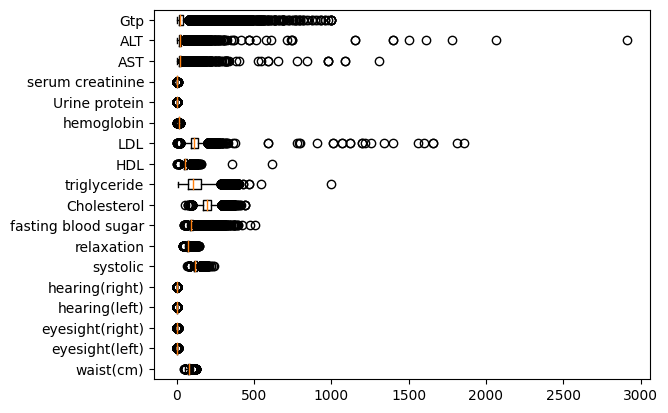

In [16]:
plt.boxplot(data.select_dtypes(include=['floating']),
            vert=False,
            labels = data.select_dtypes(include=['floating']).columns
            );
plt.show()

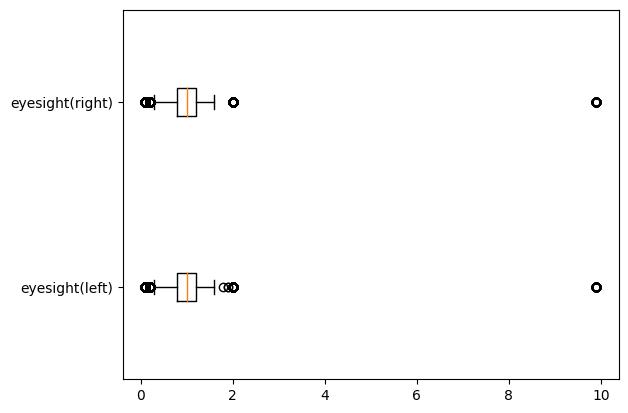

In [17]:
plt.boxplot(data[['eyesight(left)', 'eyesight(right)']],
            labels=['eyesight(left)','eyesight(right)'],
            vert=False)
plt.show()

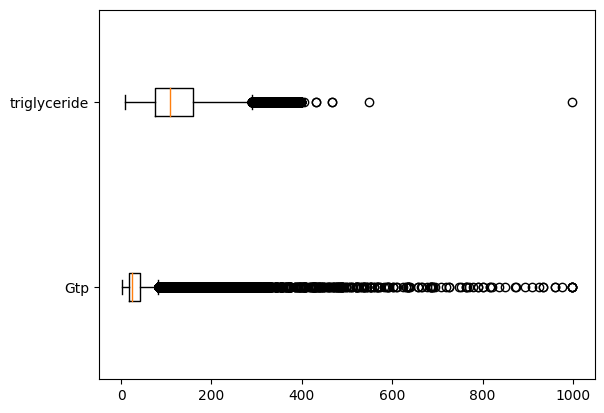

In [18]:
plt.boxplot(data[['Gtp', 'triglyceride']], vert=False, labels=['Gtp', 'triglyceride'])
plt.show()

Las columnas `eyesight(left)` y `eyesgiht(right)` tienen valores máximos de 9.9 pero la mayoría están entre cero y dos. Vamos a eliminar estos valores, ya que probablemente indican valores faltantes.

Lo mismo pasa con la variable `triglyceride` y el valor 999.

En el caso de la variable `Gtp`, hay otras observaciones cercanas al 999, en este caso parece que no es un error y lo vamos a dejar.

Como tenemos muchas observaciones y hay muy pocos valores faltantes, eliminamos las filas con valores faltantes.

In [19]:
#data = data.drop(data[data['eyesight(left)']==9.9].index)
#data = data.drop(data[data['eyesight(right)']==9.9].index)
data = data.drop(data[data['triglyceride']==999].index)
data.shape

(55691, 25)

In [20]:
print("Nos hemos quedado con el", round(data.shape[0] *100 / original_dim[0],2), "% de observaciones")

Nos hemos quedado con el 100.0 % de observaciones


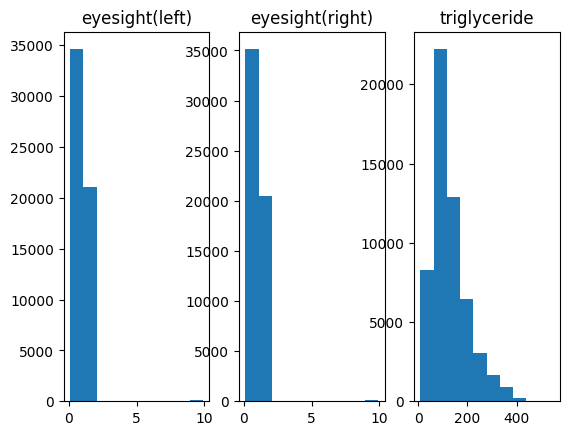

In [21]:
col = [ 'eyesight(left)', 'eyesight(right)', 'triglyceride']

for i in col:
  idx = col.index(i)
  ax = plt.subplot(1,3, idx+1)
  ax.hist(data[i])
  ax.set_title(i)
plt.rcParams["figure.figsize"] = (6,2) # hacemos las gráficas más pequeñas
plt.show()

plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"] # reset valores

#### Distribución de las variables según la clase

In [118]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55691 entries, 0 to 55691
Data columns (total 25 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               55691 non-null  int64  
 1   age                  55691 non-null  int64  
 2   height(cm)           55691 non-null  int64  
 3   weight(kg)           55691 non-null  int64  
 4   waist(cm)            55691 non-null  float64
 5   eyesight(left)       55691 non-null  float64
 6   eyesight(right)      55691 non-null  float64
 7   hearing(left)        55691 non-null  float64
 8   hearing(right)       55691 non-null  float64
 9   systolic             55691 non-null  float64
 10  relaxation           55691 non-null  float64
 11  fasting blood sugar  55691 non-null  float64
 12  Cholesterol          55691 non-null  float64
 13  triglyceride         55691 non-null  float64
 14  HDL                  55691 non-null  float64
 15  LDL                  55691 non-null 

['gender', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)', 'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic', 'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride', 'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST', 'ALT', 'Gtp', 'dental caries', 'tartar']


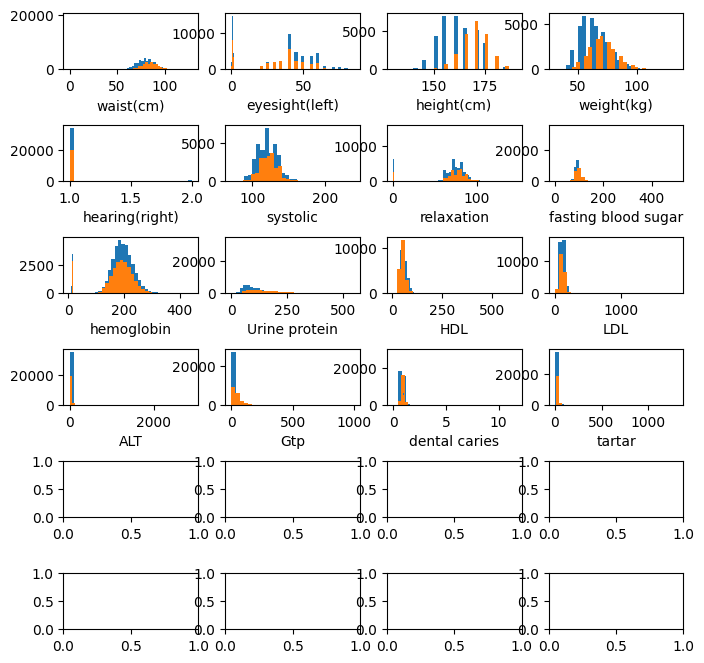

In [117]:
cols = list(data.columns)
cols.pop()
print(cols)
fig, ax = plt.subplots(ncols=4, nrows=6,
                       figsize=(8, 8))
plt.subplots_adjust(hspace=1)
for i in range(len(cols)):
    r=i//6
    c=i%4
    data[data.smoking==0][cols[i]].hist(ax=ax[r,c], label='smoking=0', color="C0", bins=30)
    data[data.smoking==1][cols[i]].hist(ax=ax[r,c], label='smoking=1', color="C1", bins=30)
    ax[r,c].set_xlabel(cols[i])
    ax[r,c].grid()

plt.show()

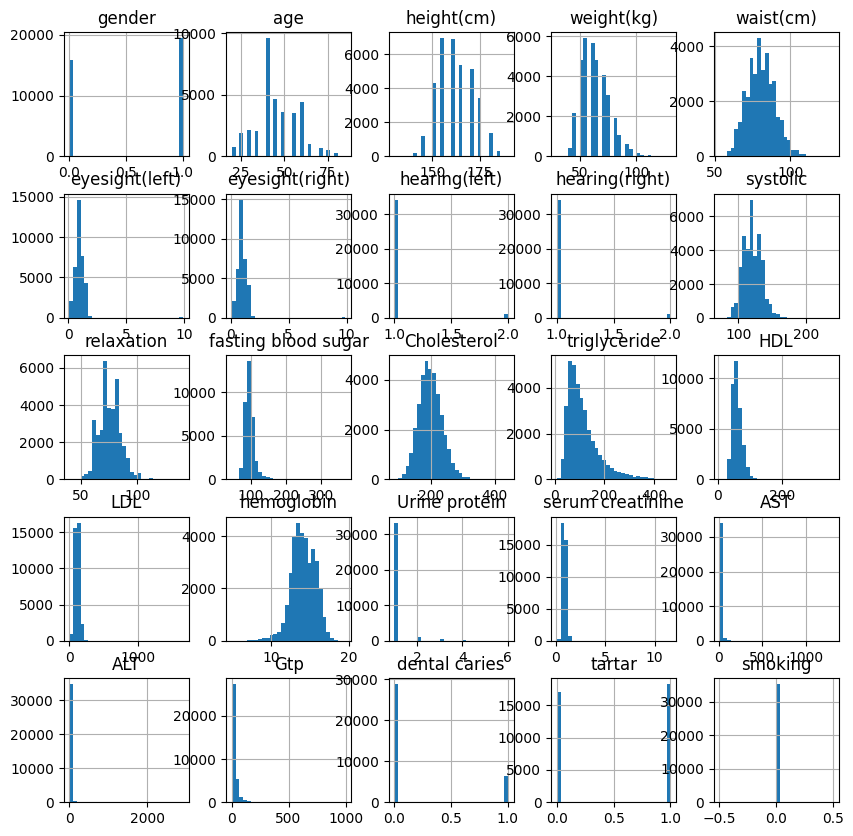

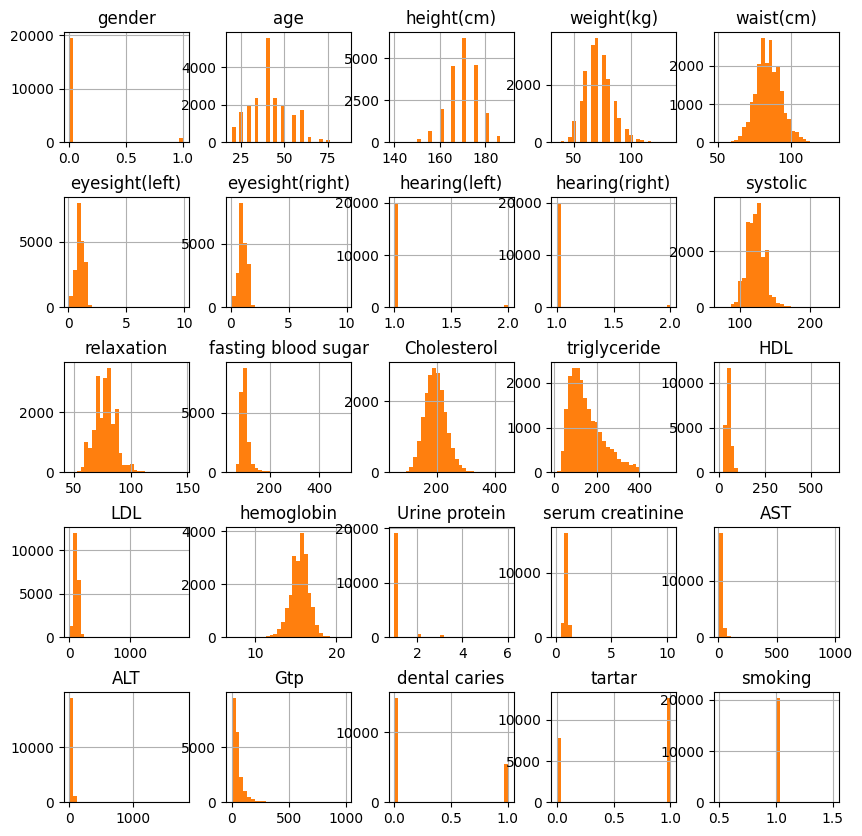

In [32]:
data[data.smoking==0].hist(bins=30,
             layout = (5,5), figsize=(10, 10)
             )
data[data.smoking==1].hist(bins=30, color="C1",
             layout = (5,5), figsize=(10, 10)
             );
plt.subplots_adjust(hspace=0.5)
plt.show()

### Balanceo del dataset

En la exploración hemos visto que teníamos mucha más cantidad de observaciones con el valor 0 que con el valor 1 en la variable predictora.

Deberíamos coger la misma cantidad de datos de las dos clases (smoking=0 vs smoking=1) para no desviar el modelo.

Vamos a realizar un undersampling.

In [ ]:
# undersampling
smoking1 = data[data['smoking']==1]
smoking0 = data[data['smoking']==0]
smoking0 = smoking0.sample(n=len(smoking1), random_state=101)
data = pd.concat([smoking0, smoking1],axis=0)
print("Nos hemos quedado con el", round(data.shape[0] *100 / original_dim[0],2), "% de observaciones")

### Separación variables explicatorias y predictiva

In [ ]:
X = data.iloc[:, :-1]
Y = data.iloc[:, -1]

print(X.shape)
print(Y.shape)

### División train/test/validation

Como tenemos un gran número de observaciones, vamos a hacer la validación de `k` con un set de validación en lugar de hacer validación cruzada.

In [ ]:
X0_train, X0_test, y0_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
X1_train, X1_val, y_train, y_val = train_test_split(X0_train, y0_train, test_size=0.2, random_state=0)

print("Observaciones de train:", X1_train.shape[0])
print("Observaciones de validación:",X1_val.shape[0])
print("Observaciones de test:", X0_test.shape[0])

!!!!!!! FALTA COMPROVAR QUE LES OBSERVACIONES ESTIGUIN BALANDEJADES EN ELS SETS !!!!!!!!! PROVA XI QUADRAT

### Normalización

In [ ]:
transformer = StandardScaler().fit(X1_train)
X_train = transformer.transform(X1_train)
X_val = transformer.transform(X1_val)
X_test = transformer.transform(X0_test)

### Modelo KNN

#### Entreno del modelo con varias k en el conjunto de validación

In [ ]:
k_list = [1, 10, 50, 100, 200, 1000]

# Dibujamos los errores de entrenamiento y de test en función del parámetro k
n_tr = X_train.shape[0]
pe_tr = []
pe_val = []

for k in k_list:
    # creación y entreno del modelo
    KNN_k = KNeighborsClassifier(n_neighbors=k)
    KNN_k.fit(X_train, y_train)

    # Errores de entrenamiento
    Z_tr = KNN_k.predict(X_train)
    E_tr = Z_tr.flatten()!=y_train

    # Errores de val
    Z_tst = KNN_k.predict(X_val)
    E_val = Z_tst.flatten()!=y_val

    # Tasas de error
    pe_tr.append(np.mean(E_tr))
    pe_val.append(np.mean(E_val))

# buscamos k óptima
k_opt = k_list[np.argmin(pe_val)]
print('El valor óptimo de k es ' + str(k_opt))

In [ ]:
# graficamos
plt.plot(np.log10(k_list), pe_tr,'b--o',label='Training error')
plt.plot(np.log10(k_list), pe_val,'g--o',label='Validation error')
plt.stem([np.log10(k_opt), np.log10(k_opt)], [0, min(pe_val)],'r-o', label='Optimal k')
plt.xlabel('$log(k)$')
plt.ylabel('Tasa de error')
plt.legend(loc='best')

#### Evaluación del modelo con la mejor k

In [ ]:
clf = KNeighborsClassifier(k_opt)
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
pe_tst = np.mean(y_test != y_test_pred)
print('Tasa de error', round(pe_tst,2), "con k = ", k_opt)

In [ ]:
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test)

# Modelo Random Forest



In [ ]:
# entreno modelo sencillo, no buscamos parámetros
rf = RandomForestClassifier(random_state =42)
rf.fit(X_train, y_train)

pred_tr = rf.predict_proba(X_train)[:,1]
pred_va = rf.predict_proba(X_val)[:,1]

print(roc_auc_score(y_train,pred_tr))
print(roc_auc_score(y_val,pred_va))

In [ ]:
# búsqueda parámetros óptimos con validación cruzada

param_grid = {'n_estimators' : [50,100,150],
              'max_depth' : [2,5,10]}
clf = GridSearchCV(RandomForestClassifier(random_state = 42), param_grid, cv=2)
clf.fit(X_train, y_train)

# X_train = transformer.transform(X1_train)
# X_val = transformer.transform(X1_val)
# X_test = transformer.transform(X0_test)

print(clf.best_params_)
print(clf.best_score_)
print(clf.score(X_test, y_test))


X0_train = transformer.transform(X0_train)

clf.fit(X0_train, y0_train)
print(clf.best_params_)
print(clf.best_score_)
print(clf.score(X_val, y_val))

In [ ]:
# búsqueda parámetros óptimos sin validación cruzada

# Define your parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

best_score = 0
best_params = {}

# Create a list of parameter combinations
param_combinations = list(ParameterGrid(param_grid))

# Define a function to train and evaluate the model for a given parameter combination
def train_and_evaluate(params):
    # Create and fit the Random Forest model with the current parameters
    model = RandomForestClassifier(
        n_estimators=params['n_estimators'],
        max_depth=params['max_depth'],
        min_samples_split=params['min_samples_split']
    )
    model.fit(X_train, y_train)

    # Make predictions on the holdout validation set
    y_pred = model.predict(X_val)

    # Calculate accuracy score
    score = accuracy_score(y_val, y_pred)

    return params, score

# Parallelize the grid search process
results = Parallel(n_jobs=-1)(delayed(train_and_evaluate)(params) for params in param_combinations)

In [ ]:
# Convert the results to a numpy array
param_scores = np.array([(params, score) for params, score in results])

# Extract the parameter values and scores
parameters = [params for params, _ in param_scores]
scores = [score for _, score in param_scores]

# Create separate columns for each parameter
df = pd.DataFrame(parameters, columns=['n_estimators', 'max_depth', 'min_samples_split'])
df['Score'] = scores

# Color the cells based on the 'Score' column
df_styled = df.style.background_gradient(cmap='coolwarm', subset=['Score'])

# Display the styled DataFrame
display(df_styled)

In [ ]:
# Iterate over the results and find the best parameters
for params, score in results:
    if score > best_score:
        best_score = score
        best_params = params

print("Best parameters:", best_params)
print("Best accuracy score:", best_score)

## Evaluación mejor modelo Random forest

In [ ]:
# Initialize and train the random forest model with the best parameters
model = RandomForestClassifier(**best_params)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the accuracy of the model on the test set
print("Best parameters:", best_params)
print("Accuracy on test set:", accuracy_score(y_test, y_pred))